## หาทางควบคุมให้ค่าในแต่ละชั้นอยู่ภายในช่วงที่เหมาะสมตลอดเวลา
# แบตช์นอร์ม (batch norm)
![BN](https://phyblas.hinaboshi.com/rup/nayuki/umaki/r01.png)

### นี่เป็นเทคนิคที่ถูกคิดขึ้นมาในปี 2015 แต่ได้รับความนิยมสูงมากอย่างรวดเร็ว
### - แบตช์นอร์มมีความสามารถดังนี้
    - ทำให้การเรียนรู้คืบหน้าไปได้อย่างรวดเร็วขึ้น
    - ทำให้ไม่ต้องใส่ใจกับค่าพารามิเตอร์ตั้งต้นมากนัก
    - ป้องกันการเรียนรู้เกินได้


# Calculation
#### ชั้นแบตช์นอร์มจะทำการปรับค่าข้อมูลที่ผ่านให้เป็นมาตรฐานโดยเทียบกับข้อมูลทั้งหมด

## $$
\begin{align}
\mu_B &=& \frac{1}{n} \sum_{i=0}^{n-1} x_i \\
x_{C,i} &=& x_i-\mu_B \\
\sigma_B^2 &=& \frac{1}{n} \sum_{i=0}^{n-1} x_{C,i}^2 \\
x_{N,i} &=& \frac{x_{C,i}}{\sqrt{\sigma_B^2+\epsilon}}
\end{align}
$$
#### โดยในที่นี้ x คือค่าตัวแปรต่างๆในแต่ละชั้น เสร็จแล้วก็จะได้ค่า xC ที่มีค่าเฉลี่ยเป็น 0 ส่วนเบี่ยงเบนมาตรฐานเป็น 1
#### แต่การคำนวณในชั้นนี้ยังไม่จบแค่นั้น ยังต้องมีการไปคูณและบวกกับพารามิเตอร์เพื่อปรับค่าให้เหมาะสมอีกที

## $$ \begin{align}
x_{B,i} = \gamma x_{N,i} + \beta
\end{align} $$
## โดย γ และ β เป็นพารามิเตอร์ที่ต้องทำการเรียนรู้
### คือตั้งให้ γ=1 และ β=0 คงที่

# \begin{align}
\mu_{R,ใหม่} = m\mu_{R,เดิม} + (1-m)\mu_B \\
\sigma_{R,ใหม่}^2 = m\sigma_{R,เดิม}^2 + (1-m)\sigma_B^2
\end{align}

In [5]:
import sys
sys.path.insert(1, '../../Side Stories/')
from unagi import Chan, Affin, Relu, Sigmoid_entropy, Adam, Batchnorm, Param

In [6]:
import numpy as np

In [7]:
class Batchnorm(Chan):
    def __init__(self, m, mmt=.9):
        self.m = m
        self.param = [Param(np.ones(m)), Param(np.zeros(m))]
        self.rmu = np.zeros(m) # average at runtime
        self.rvar = np.zeros(m) + 1e-8
        self.mmt = mmt
        self.is_train = 1
        
    def pai(self, x):
        if self.is_train:
            self.n = len(x)
            mu = x.mean(0)
            self.xc = x - mu
            var = (self.xc**2).mean(0) + 1e-8
            self.sigma = np.sqrt(var)
            self.xn = xn = self.xc / self.sigma
            self.rmu = self.mmt*self.mu + (1.-self.mmt)*mu
            self.rvar = self.mmt*self.rvar + (1.-self.mmt)*var
        else:
            xc = x - self.rmu
            xn = xc / np.sqrt(self.rvar)
        return self.param[0].kha*xn + self.param[1].kha
    
    def yon(self, g):
        self.param[0].g = (g*self.xn).sum(0)
        self.param[1].g = g.sum(0)
        gxn = self.param[0].kha*g
        gsigma = -((gxn*self.xc)/self.sigma**2).sum(0)
        gvar = gsigma/self.sigma/2
        gxc = gxn/self.sigma + (2./self.n)*self.xc*gvar
        gmu = gxc.sum(0)
        gx = gxc - gmu/self.n
        return gx
                

# เปรียบเทียบผลของการมีแบตช์นอร์มกับไม่มี
### โดยเราจะเทียบใน ๒ กรณี คือกรณีที่กำหนดค่าพารามิเตอร์น้ำหนักตั้งต้นอย่างเหมาะสมดีแล้ว คือใช้ค่า σ ตั้งต้นแบบเหอ ไข่หมิง (ดูบทที่ ๑๓) และอีกแบบคือใช้ค่าตั้งต้นที่ต่ำเกินควร คือให้ σ เป็น 0.1 เท่าของเหอ ไข่หมิง ทั้ง ๒ กรณีลองทั้งแบบมีแบตช์นอร์มและไม่มี ดังนั้นรวมแล้วเป็น ๔ กรณี


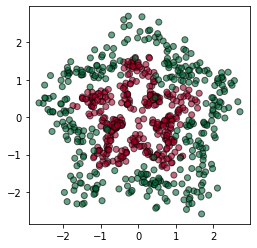

In [9]:
import matplotlib.pyplot as plt
  
n = 350
t = np.random.uniform(0,360,n*2)
r = [np.random.normal(1+0.4*np.sin(np.radians(t[:n])*5),0.2)]
r += [np.random.normal(2+0.4*np.sin(np.radians(t[n:])*5),0.3)]
r = np.hstack(r)
x = r*np.cos(np.radians(t))
y = r*np.sin(np.radians(t))
z = np.repeat([0,1],n)
X = np.array([x,y]).T

plt.axes(aspect=1)
plt.scatter(X[:,0],X[:,1],c=z,edgecolor='k',alpha=0.6,cmap='RdYlGn')
plt.show()

AttributeError: 'Batchnorm' object has no attribute 'mu'

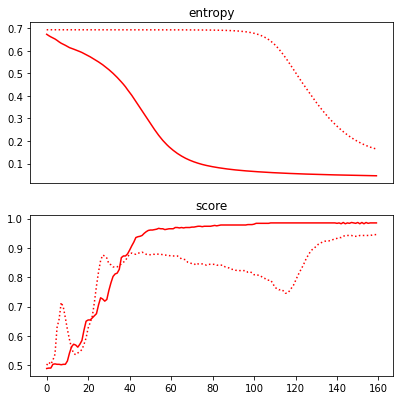

In [10]:
plt.figure(figsize=[6.5,6.5])
ax1 = plt.subplot(211,xticks=[])
ax1.set_title('entropy')
ax2 = plt.subplot(212)
ax2.set_title('score')

m = [2,60,60,60,1] # จำนวนเซลล์ในชั้นต่างๆ
n_thamsam = 160 # จำนวนรอบที่ทำซ้ำเพื่อปรับพารามิเตอร์
for b in [0,1]:
    for s in [0.1,1]:
        # กำหนดแบบจำลอง
        chan = []
        param = []
        for i in range(len(m)-1):
            he_kaiming = np.sqrt(2./m[i]) # ค่าน้ำหนักตั้งต้นแบบเหอ ไข่หมิง
            af = Affin(m[i],m[i+1],he_kaiming*s)
            chan.append(af)
            param.extend(af.param)
            if(i<len(m)-2):
                if(b): # ใส่ชั้นแบตช์นอร์ม
                    bn = Batchnorm(m[i+1])
                    chan.append(bn)
                    param.extend(bn.param)
                chan.append(Relu())
        chan.append(Sigmoid_entropy())
        opt = Adam(param,eta=0.001) # ออปทิไมเซอร์
        
        # เริ่มฝึก
        lis_entropy = []
        lis_khanaen = []
        for i in range(n_thamsam):
            # คำนวนไปข้างหน้าในโหมดฝึก เพื่อหาเอนโทรปีแล้วแพร่ย้อนกลับ
            X_ = X
            for c in chan[:-1]:
                c.fuekyu = 1 # ฝึกอยู่
                X_ = c(X_)
            entropy = chan[-1](X_,z)
            lis_entropy.append(entropy.kha) # บันทึกค่าเอนโทรปี
            entropy.phraeyon() # แพร่ย้อนกลับ
            opt() # ปรับพารามิเตอร์
            # คำนวณไปข้างหน้าใหม่ในโหมดใช้งานจริง เพื่อหาคะแนนความแม่นในการทำนาย
            X_ = X
            for c in chan[:-1]:
                c.fuekyu = 0 # ไม่ได้ฝึกอยู่
                X_ = c(X_)
            lis_khanaen.append(((X_.kha.ravel()>0)==z).mean()) # บันทึกคะแนน
            
        ax1.plot(lis_entropy,[':','-'][s==1],color=['r','g'][b])
        ax2.plot(lis_khanaen,[':','-'][s==1],color=['r','g'][b])
plt.legend([u'ไม่มีแบตช์นอร์ม, $\sigma_w$=เหอ/10',
            u'ไม่มีแบตช์นอร์ม, $\sigma_w$=เหอ',
            u'มีแบตช์นอร์ม, $\sigma_w$=เหอ/10',
            u'มีแบตช์นอร์ม, $\sigma_w$=เหอ'],
    )
plt.tight_layout()
plt.show()